In [2]:
# TensorFlow Tutorials
# ML basics with Keras 
# Text classificaiton with TF Hub
# https://www.tensorflow.org/tutorials/keras/text_classification_with_hub
# tfds.load: https://www.tensorflow.org/datasets/api_docs/python/tfds/load
# imdb tfds dataset: https://www.tensorflow.org/datasets/catalog/imdb_reviews
# TF Hub (Transfer Learning): https://www.tensorflow.org/hub
  # https://tfhub.dev/s?module-type=text-embedding
  # https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
  # https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1
  # https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1
  # https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1

# TF Hub Keraslayer: https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer
# TF Keras regularizers: https://keras.io/api/layers/regularizers/    https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
# TF Keras Cnv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
# TF Keras LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

# Live training plots: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e



import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import *

!pip install -q tensorflow-Hub
!pip install -q tfds-nightly

import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


starttime = datetime.now()


# Download the IMDB dataset:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:85%]', 'train[85%:]', 'test'),
    as_supervised=True)


# Explore the dataset:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
# First 10 examples:
print(train_examples_batch)
# First 10 labels:
print(train_labels_batch)

# test_examples_batch, test_labels_batch = next(iter(test_data.batch(10)))


et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )

2.2.0
     |████████████████████████████████| 3.3MB 2.8MB/s 
TF Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
GPU is available


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU8RSQS/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU8RSQS/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteU8RSQS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being

## Build the model

The neural network is created by stacking layers—this requires three main architectural decisions:

* How to represent the text?
* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into embeddings vectors. We can use a pre-trained text embedding as the first layer, which will have three advantages:

*   we don't have to worry about text preprocessing,
*   we can benefit from transfer learning,
*   the embedding has a fixed size, so it's simpler to process.

For this example we will use a **pre-trained text embedding model** from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1).

There are three other pre-trained models to test for the sake of this tutorial:

* [google/tf2-preview/gnews-swivel-20dim-with-oov/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) - same as [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1), but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
* [google/tf2-preview/nnlm-en-dim50/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1) - A much larger model with ~1M vocabulary size and 50 dimensions.
* [google/tf2-preview/nnlm-en-dim128/1](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1) - Even larger model with ~1M vocabulary size and 128 dimensions.

Let's first create a Keras layer that uses a TensorFlow Hub model to embed the sentences, and try it out on a couple of input examples. Note that no matter the length of the input text, the output shape of the embeddings is: `(num_examples, embedding_dimension)`.


In [6]:
# Creating a Keras layer that uses TF Hub
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" # "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"  # "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"  #  
hub_layer20 = hub.KerasLayer(embedding, input_shape=[], #output_shape=[20],
                           dtype=tf.string, trainable=True)

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"   
hub_layer20oov = hub.KerasLayer(embedding, input_shape=[], output_shape=[20],
                           dtype=tf.string, trainable=False)

embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"   
hub_layer50 = hub.KerasLayer(embedding, input_shape=[], output_shape=[50],
                           dtype=tf.string, trainable=False)

embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1" 
hub_layer128 = hub.KerasLayer(embedding, input_shape=[], output_shape=[128],
                           dtype=tf.string, trainable=False)

# embedding three sentences:
embeddings = hub_layer20(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape)  #(3,128)
print(embeddings[0,:])

# embedding three train examples:
print(hub_layer20(train_examples_batch[:3]))


# Build a train model:
model = tf.keras.Sequential()
# The first layer is a TensorFlow Hub layer. This layer uses a pre-trained Saved Model to map a sentence into its embedding vector. The pre-trained text embedding model that we are using (google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).
model.add(hub_layer20)
model.add(tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1)))
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu')) #, strides=1, padding='causal')   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))
# model.add(tf.keras.layers.Flatten())   # enable if we don't use the LSTM layer! comment if we use the LSTM!
# model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer=Adam(lr=0.01),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)




(3, 20)
tf.Tensor(
[-0.78908336 -0.7168393  -0.53353924  0.80905694  0.87336546 -0.33993196
 -0.71978265  0.26603657  1.0945361  -0.67022246 -0.19798043 -0.10712434
 -0.11301232 -0.02264325 -0.51095414  1.4069957  -0.70042825 -1.0825775
 -0.8024444  -0.51070786], shape=(20,), dtype=float32)
tf.Tensor(
[[ 1.765786   -3.882232    3.9134233  -1.5557289  -3.3362343  -1.7357955
  -1.9954445   1.2989551   5.081598   -1.1041286  -2.0503852  -0.72675157
  -0.65675956  0.24436149 -3.7208383   2.0954835   2.2969332  -2.0689783
  -2.9489717  -1.1315987 ]
 [ 1.8804485  -2.5852382   3.4066997   1.0982676  -4.056685   -4.891284
  -2.785554    1.3874227   3.8476458  -0.9256538  -1.896706    1.2113281
   0.11474707  0.76209456 -4.8791065   2.906149    4.7087674  -2.3652055
  -3.5015898  -1.6390051 ]
 [ 0.71152234 -0.6353217   1.7385626  -1.1168286  -0.5451594  -1.1808156
   0.09504455  1.4653089   0.66059524  0.79308075 -2.2268345   0.07446612
  -1.4075904  -0.70645386 -1.907037    1.4419787   1.95518

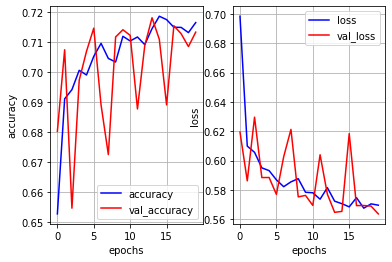

167/167 [==============================] - 4s 26ms/step - loss: 0.5696 - accuracy: 0.7165 - val_loss: 0.5637 - val_accuracy: 0.7133


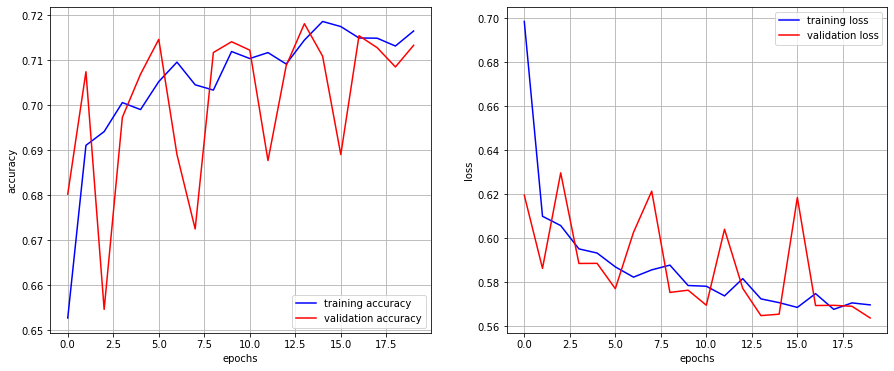



49/49 [==============================] - 2s 50ms/step - loss: 0.5736 - accuracy: 0.7125
Test accuracy: 71.25%
49/49 [==============================] - 2s 49ms/step - loss: 0.5736 - accuracy: 0.7125
loss: 0.574
accuracy: 0.712


[[0.4933556 ]
 [0.6760748 ]
 [0.7049601 ]
 [0.14213862]
 [0.70204127]
 [0.63149315]
 [0.7926877 ]
 [0.9311443 ]
 [0.2802036 ]
 [0.4135649 ]]
test example 0, label: [1] vs prediction: [0]
test example 1, label: [1] vs prediction: [1]
test example 2, label: [0] vs prediction: [1]
test example 3, label: [0] vs prediction: [0]
test example 4, label: [1] vs prediction: [1]
test example 5, label: [1] vs prediction: [1]
test example 6, label: [1] vs prediction: [1]
test example 7, label: [1] vs prediction: [1]
test example 8, label: [0] vs prediction: [0]
test example 9, label: [1] vs prediction: [0]
0
0

-> Elapsed execution time: 114.3289 seconds.



In [7]:
starttime = datetime.now()


# Callback for training target:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        target=0.9999
        if logs['accuracy']>target :
            print('\nReached %0.2f%% training accuracy. Training converged!' %(target*100))
            self.model.stop_training = True
        
            
callback = myCallback()


# Callback for Live Training Plots:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accu = []
        self.val_accu = []
        
        self.fig = plt.figure(figsize=(15,6))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accu.append(logs.get('accuracy'))
        self.val_accu.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        
        plt.subplot(1,2,1)
        plt.plot(self.x, self.accu, 'b', label="accuracy")
        plt.plot(self.x, self.val_accu, 'r', label="val_accuracy")
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.x, self.losses, 'b', label="loss")
        plt.plot(self.x, self.val_losses, 'r', label="val_loss")
        plt.grid()
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

        plt.show();


plot_losses = PlotLosses()


# Train the model:
history = model.fit(
    train_data.shuffle(10000).batch(128),
    # train_data,
    # batch_size=512,  # I don't know why it doesn't work. For some reason, the data needs to be added to .batch()
    epochs= 20,
    validation_data= validation_data.batch(128),
    callbacks= [callback, plot_losses],
    verbose= 1
    )


# Plot the training curves:
loss = history.history['loss']
accu = history.history['accuracy']
val_loss = history.history['val_loss']
val_accu = history.history['val_accuracy']

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(accu, 'b', label='training accuracy')
plt.plot(val_accu, 'r', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.show()

print('\n')


# Evaluate accuracy: compare how the model performs on the test dataset:
test_loss, test_accu = model.evaluate(test_data.batch(512), verbose=1)
print('Test accuracy: %0.2f%%' %(test_accu*100))

results = model.evaluate(test_data.batch(512), verbose=1)
for name, value in zip(model.metrics_names, results):
  print('%s: %0.3f' %(name,value))


print('\n')


# Make predictions:
# predicting the labels for the test set:
predictions = model.predict(test_data.batch(512))
# prediction on 10 test examples:
print(predictions[:10])

test_examples, test_labels = next(iter(test_data.batch(10)))
i = 0
for lab, pred in zip(test_labels.numpy(), predictions):
  if i<10 :
    print('test example %d, label: [%s] vs prediction: %s' %(i,lab,(pred>0.5).astype('int32')))
  else :
    break
  i+=1

print(int(0.3))
print(int(0.6))

et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )